# Exercise 5 - Advanced Statistics for Physics Analysis (A.Y. 2022-2023)
by Erica Brisigotti (2097202)

In [1]:
library('coda')
library('rjags')
library('tidyverse')

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs

‚îÄ‚îÄ Attaching core tidyverse packages ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ tidyverse 2.0.0 ‚îÄ‚îÄ
‚úî dplyr     1.1.2     ‚úî readr     2.1.4
‚úî forcats   1.0.0     ‚úî stringr   1.5.0
‚úî ggplot2   3.4.2     ‚úî tibble    3.2.1
‚úî lubridate 1.9.2     ‚úî tidyr     1.3.0
‚úî purrr     1.0.1     
‚îÄ‚îÄ Conflicts ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ tidyverse_conflicts() ‚îÄ‚îÄ
‚úñ dplyr::filter() masks stats::filter()
‚úñ dplyr::lag()    masks stats::lag()
‚Ñπ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
my_median <- function(post_d, mu, delta_mu){
    cum_d <- cumsum(post_d)*delta_mu
    d_median <- mu[which(cum_d >= 0.5)][1]
    return (d_median)}

In [3]:
my_credibility_interval <- function(post_d, mu, delta_mu){
    cum_d <- cumsum(post_d)*delta_mu
    low_lim <- mu[which(cum_d >= 0.025)][1]
    up_lim <- mu[which(cum_d >= 0.975)][1]
    return (c(low_lim,up_lim))}

In [4]:
my_norm <- function(z, delta){ z/( delta*sum(z) ) }

In [5]:
my_mode <- function(y, dist){ y[which(dist ==max(dist))] }

In [6]:
my_mean <- function(y, dist){ sum(y*dist)/sum(dist) }

In [7]:
my_std <- function(y, dist){
    m = my_mean(y,dist)
    return (sum(y0-m)**2/sum(dist))**0.5 }

## Exercise 1
Ladislaus Josephovich Bortkiewicz was a Russian economist and statistician. He noted that the Poisson distribution can be very useful in applied statistics when describing low-frequency events in a large population. In a famous example he showed that the number of deaths by horse kick among the Prussian army follows the Poisson distribution.

Considering the following to sets of observations taken over a fixed large time interval in two different corps:

$$
\begin{matrix}
      \text{y death soldiers} & 0 & 1 & 2 & 3 & 4 & \geq 5 \\
      \hline
      n_1 \text{observations} & 109 & 65 & 22 & 3 & 1 & 0 \\
      n_2 \text{observations} & 144 & 91 & 32 & 11 & 2 & 0\\
\end{matrix}
$$

In [8]:
delta_y <- 0.001
y <- seq(0,5,delta_y)
y0 <- seq(0,5,1)
n_1 <- c(109,65,22,3,1,0)
n_2 <- c(144,91,32,11,2,0)

In [9]:
# I decide to summarize each set of observations with their mean
m_1 <- my_mean(y0,n_1)
m_2 <- my_mean(y0,n_2)

<span style="color:blue"> Since the process is the Posson, I can exploit the property that returns, from a Gamma$(\alpha,\lambda)$ prior, a Gamma$(\alpha^\prime = \alpha + \sum y , \lambda^\prime = \lambda + n )$ posterior. </span>

- assuming a uniform prior, compute and plot the posterior distribution for Œª, the death rate over the measurement time. Determine the posterior mean, median and variance, and compute the 95% credibility interval

In [10]:
# a uniform prior is a Gamma(1,0)
alpha_prior <- 1
lambda_prior <- 0
# from the parameters of the Gamma prior, I get the parameters of the Gamma posterior based on the known formulas
alpha_post_1 <- alpha_prior + m_1
lambda_post_1 <- lambda_prior + 1
alpha_post_2 <- alpha_prior + m_2
lambda_post_2 <- lambda_prior + 1
post_dist_1 <- my_norm(dgamma(y, alpha_post_1, lambda_post_1), delta_y)
post_dist_2 <- my_norm(dgamma(y, alpha_post_2, lambda_post_2), delta_y)

In [11]:
# I extract the estimators
# for the mean and the standard deviation, I use the known formulas
mean_1 <- alpha_post_1/lambda_post_1
mean_2 <- alpha_post_2/lambda_post_2
var_1 <- alpha_post_1/lambda_post_1**2
var_2 <- alpha_post_2/lambda_post_2**2
# for the remaining ones, I do it manually
med_1 <- my_median(post_dist_1, y, delta_y)
med_2 <- my_median(post_dist_2, y, delta_y)
lim_1 <- my_credibility_interval(post_dist_1, y, delta_y)
lim_2 <- my_credibility_interval(post_dist_2, y, delta_y)
mode_1 <- my_mode(y, post_dist_1)
mode_2 <- my_mode(y, post_dist_2)

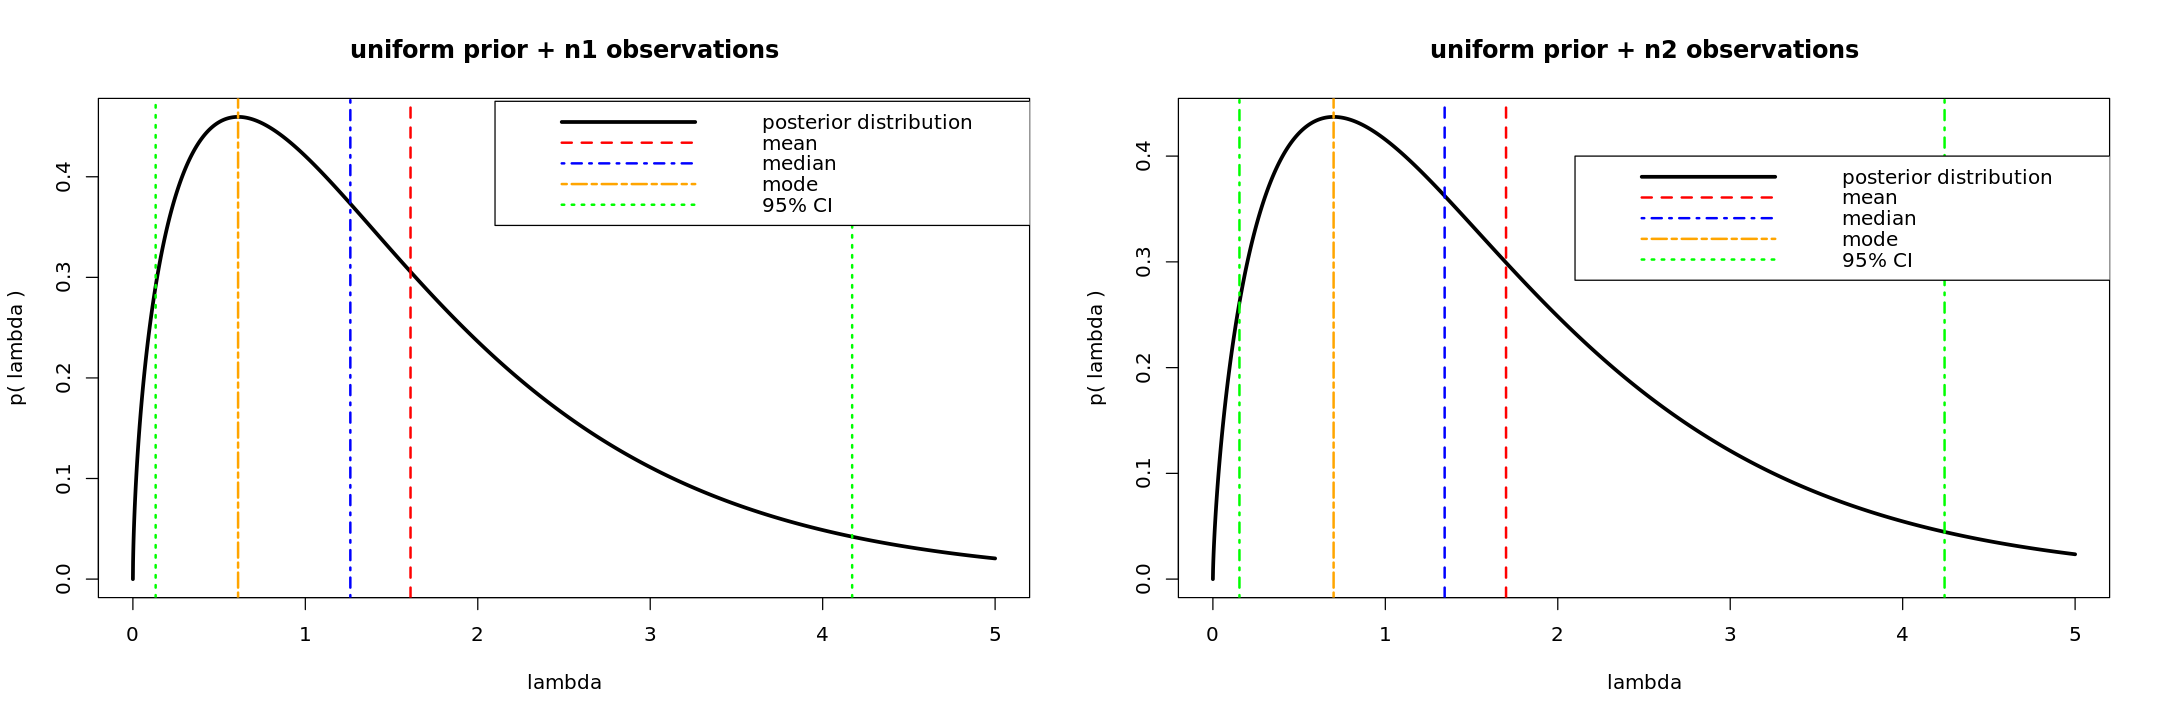

In [12]:
options(repr.plot.width=18, repr.plot.height=6)
par( mfrow=c(1,2) )

plot(y, post_dist_1, col='black', type='l', lwd=3, lty=1, main="uniform prior + n1 observations", xlab='lambda',
     ylab='p( lambda )')
abline(v=mean_1, col='red', lwd=2, lty=2)
abline(v=med_1, col='blue', lwd=2, lty=4)
abline(v=mode_1, col='orange', lwd=2, lty=6)
abline(v=lim_1, col='green', lwd=2, lty=3)
legend(2.1, 0.475, legend=c("posterior distribution","mean",'median','mode','95% CI'),
       col=c('black','red','blue','orange','green'), lty = c(1, 2, 4, 6, 3), lwd=c(3, 2, 2, 2, 2))

plot(y, post_dist_2, col='black', type='l', lwd=3, lty=1, main="uniform prior + n2 observations", xlab='lambda',
     ylab='p( lambda )')
abline(v=mean_2, col='red', lwd=2, lty=2)
abline(v=med_2, col='blue', lwd=2, lty=2)
abline(v=mode_2, col='orange', lwd=2, lty=6)
abline(v=lim_2, col='green', lwd=2, lty=4)
legend(2.1, 0.4, legend=c("posterior distribution","mean",'median','mode','95% CI'),
       col=c('black','red','blue','orange','green'), lty = c(1, 2, 4, 6, 3), lwd=c(3, 2, 2, 2, 2))

- assuming now a Jeffreys‚Äô prior, $$ g(\lambda) ‚àù 1/\sqrt{\lambda} \;\; \text{with} \;\; Œª > 0 $$ compute and plot the posterior distribution for Œª, the death rate over the measurement time. Determine the posterior mean, median and variance, and compute the 95% credibility interval.


In [13]:
# a Jeffreys' prior is a Gamma(0.5,0)
alpha_prior <- 0.5
lambda_prior <- 0
# from the parameters of the Gamma prior, I get the parameters of the Gamma posterior based on the known formulas
alpha_post_1 <- alpha_prior + m_1
lambda_post_1 <- lambda_prior + 1
alpha_post_2 <- alpha_prior + m_2
lambda_post_2 <- lambda_prior + 1
post_dist_1 <- my_norm(dgamma(y, alpha_post_1, lambda_post_1), delta_y)
post_dist_2 <- my_norm(dgamma(y, alpha_post_2, lambda_post_2), delta_y)

In [14]:
# I extract the estimators
# for the mean and the standard deviation, I use the known formulas
mean_1 <- alpha_post_1/lambda_post_1
mean_2 <- alpha_post_2/lambda_post_2
var_1 <- alpha_post_1/lambda_post_1**2
var_2 <- alpha_post_2/lambda_post_2**2
# for the remaining ones, I do it manually
med_1 <- my_median(post_dist_1,y,delta_y)
med_2 <- my_median(post_dist_2,y,delta_y)
lim_1 <- my_credibility_interval(post_dist_1, y, delta_y)
lim_2 <- my_credibility_interval(post_dist_2, y, delta_y)
mode_1 <- my_mode(y, post_dist_1)
mode_2 <- my_mode(y, post_dist_2)

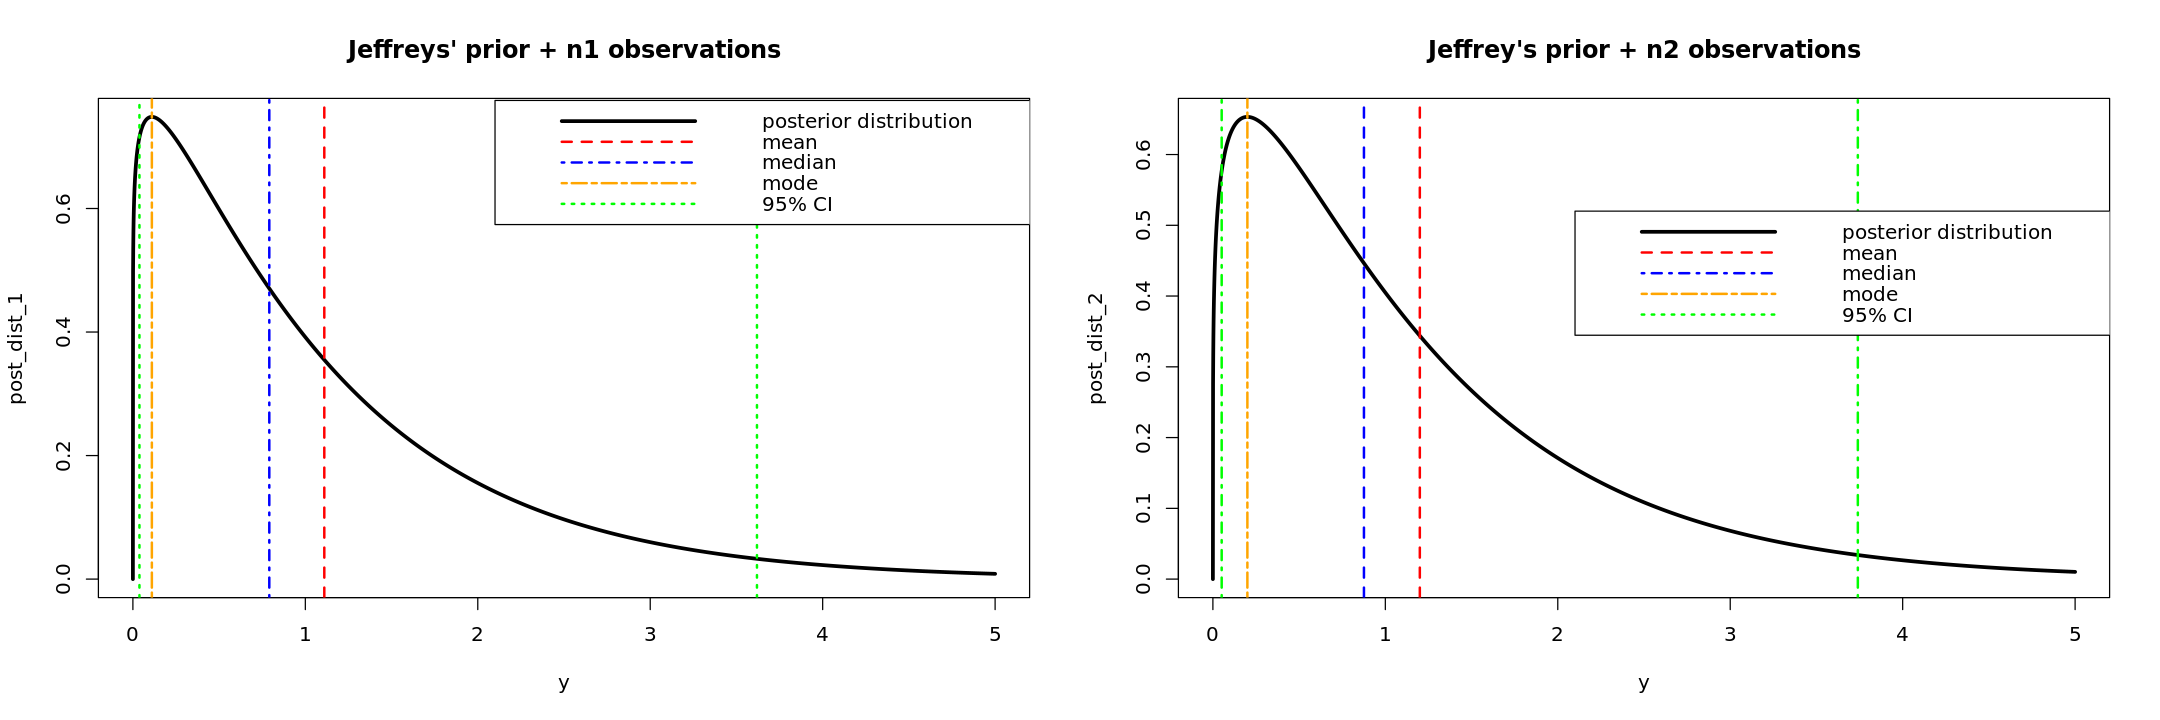

In [15]:
options( repr.plot.width=18, repr.plot.height=6)
par( mfrow=c(1,2) )

plot(y, post_dist_1, col='black', type='l', lwd=3, lty=1, main="Jeffreys' prior + n1 observations", xlim=c(0,5))
abline( v=mean_1, col='red', lwd=2, lty=2)
abline( v=med_1, col='blue', lwd=2, lty=4)
abline( v=mode_1, col='orange', lwd=2, lty=6)
abline( v=lim_1, col='green', lwd=2, lty=3)
legend(2.1, 0.775, legend=c("posterior distribution","mean",'median','mode','95% CI'),
       col=c('black','red','blue','orange','green'), lty = c(1, 2, 4, 6, 3), lwd=c(3, 2, 2, 2, 2))

plot(y, post_dist_2, col='black', type='l', lwd=3, lty=1, main="Jeffrey's prior + n2 observations", xlim=c(0,5))
abline( v=mean_2, col='red', lwd=2, lty=2)
abline( v=med_2, col='blue', lwd=2, lty=2)
abline( v=mode_2, col='orange', lwd=2, lty=6)
abline( v=lim_2, col='green', lwd=2, lty=4)
legend(2.1, 0.52, legend=c("posterior distribution","mean",'median','mode','95% CI'),
       col=c('black','red','blue','orange','green'), lty = c(1, 2, 4, 6, 3), lwd=c(3, 2, 2, 2, 2))

## Exercise 2
Solve Exercise 1 with a Markov Chain Monte Carlo. Build your own MCMC, using the functions introduced during lectures, or using a MCM library like JAGS.

In [16]:
# I design a function that is able to manage both cases (i.e. priors)
my_MCMC <- function(prior_name){  
    # this function executes the MCMC ussing rjags and choosing the prior given as an input
    # the MCMC is run for both datasets given in exercise 1, which are characterized by their averages
    # I retrieve the (poisson based) model defined in the external file
    if (prior_name == "uniform prior"){
        model <- "Brisigotti_Erica_rlab05_unif_prior_MCMC.bug"
        h_1 <- 0.47
        h_2 <- 0.44 }
    else if (prior_name == "Jeffreys' prior"){
        model <- "Brisigotti_Erica_rlab05_Jeff_prior_MCMC.bug"
        h_1 <- 2.75
        h_2 <- 2.2 }

    # I run the MCMC chain for the first dataset
    data_1 <- NULL
    # I give the mean of the first dataset as the input  
    data_1$X <- m_1 
    # I retrieve the (poisson based) model defined in the external file
    jm_1 <- jags.model(model, data_1, quiet=TRUE)
    # I update the Markov chain by setting the number of iterations
    update(jm_1, 10000)
    # I then sample from the MCMC algorithm
    chain_1 <- coda.samples(jm_1, c("lambda", "Y"), n.iter=100000)
    # and save my chain in a dataframe format
    df_1 <- as.data.frame( as.mcmc(chain_1) )

    # I run the MCMC chain for the second dataset
    data_2 <- NULL
    # I give the mean of the second dataset as the input  
    data_2$X <- m_2 
    jm_2 <- jags.model(model, data_2, quiet=TRUE)
    # I update the Markov chain by setting the number of iterations
    update(jm_2, 10000)
    # I then sample from the MCMC algorithm
    chain_2 <- coda.samples(jm_2 , c("lambda", "Y"), n.iter=100000)
    # and save my chain in a dataframe format
    df_2 <- as.data.frame( as.mcmc(chain_2) )

    # I get the pieces of information given by the histograms, which are needed to extract estimators
    temp_1 <- hist(df_1$lambda, plot=FALSE, nc=100)
    temp_2 <- hist(df_2$lambda, plot=FALSE, nc=100)

    # I update the terminology to match the wording used in the previous sections of the code
    post_dist_1 <- temp_1$density
    y_1 <- temp_1$mids
    delta_y_1 <- y_1[2]-y_1[1]
    post_dist_2 <- temp_2$density
    y_2 <- temp_2$mids
    delta_y_2 <- y_2[2]-y_2[1]
    # and extract all of the estimators manually, which I'm going to save in a dataframe
    stats <- data.frame( estimator=NA, n1_observations=NA, n2_observations=NA )
    mean_1 <- my_mean(y_1, post_dist_1)
    mean_2 <- my_mean(y_2, post_dist_2)
    stats[1,] = c('mean', mean_1, mean_2)
    var_1 <- (my_std(y_1, post_dist_1))**2
    var_2 <- (my_std(y_2, post_dist_2))**2
    stats[2,] = c('variance', var_1, var_2)
    med_1 <- my_median(post_dist_1, y_1, delta_y_1)
    med_2 <- my_median(post_dist_2, y_2, delta_y_2)
    stats[3,] = c('median', med_1, med_2)
    lim_1 <- my_credibility_interval(post_dist_1, y_1, delta_y_1)
    lim_2 <- my_credibility_interval(post_dist_2, y_2, delta_y_1)
    stats[4,] = c('low_lim_CI', lim_1[1], lim_2[1])
    stats[5,] = c('up_lim_CI', lim_1[2], lim_2[2])
    mode_1 <- my_mode(y_1, post_dist_1)
    mode_2 <- my_mode(y_2, post_dist_2)
    stats[6,] = c('mode', mode_1, mode_2)

    # I can finally plot everything I want to show, all together
    options( repr.plot.width=18, repr.plot.height=6)
    par( mfrow=c(1,2) )

    plot(y_1, post_dist_1, col='black', type='l', lwd=3, lty=1, main="uniform prior + n1 observations", xlab='lambda',
         ylab='p( lambda )', xlim=c(0,5))
    abline(v=mean_1, col='red', lwd=2, lty=2)
    abline(v=med_1, col='blue', lwd=2, lty=4)
    abline(v=mode_1, col='orange', lwd=2, lty=6)
    abline(v=lim_1, col='green', lwd=2, lty=3)
    legend(2.1, h_1, legend=c("posterior distribution","mean",'median','mode','95% CI'),
           col=c('black','red','blue','orange','green'), lty = c(1, 2, 4, 6, 3), lwd=c(3, 2, 2, 2, 2))

    plot(y_2, post_dist_2, col='black', type='l', lwd=3, lty=1, main="uniform prior + n2 observations", xlab='lambda',
         ylab='p( lambda )', xlim=c(0,5))
    abline(v=mean_2, col='red', lwd=2, lty=2)
    abline(v=med_2, col='blue', lwd=2, lty=2)
    abline(v=mode_2, col='orange', lwd=2, lty=6)
    abline(v=lim_2, col='green', lwd=2, lty=4)
    legend(2.1, h_2, legend=c("posterior distribution","mean",'median','mode','95% CI'),
           col=c('black','red','blue','orange','green'), lty = c(1, 2, 4, 6, 3), lwd=c(3, 2, 2, 2, 2))
    
    stats %>% mutate( n1_observations=as.numeric(n1_observations), n2_observations=as.numeric(n2_observations) ) -> stats
    stats
    }

- assuming a uniform prior, compute and plot the posterior distribution for Œª, the death rate over the measurement time. Determine the posterior mean, median and variance, and compute the 95% credibility interval

estimator  n1_observations n2_observations
1 mean       1.617512         1.698882      
2 variance   7.860320        21.352609      
3 median     1.250000         1.300000      
4 low_lim_CI 0.150000         0.300000      
5 up_lim_CI  4.850000               NA      
6 mode       0.650000         0.700000

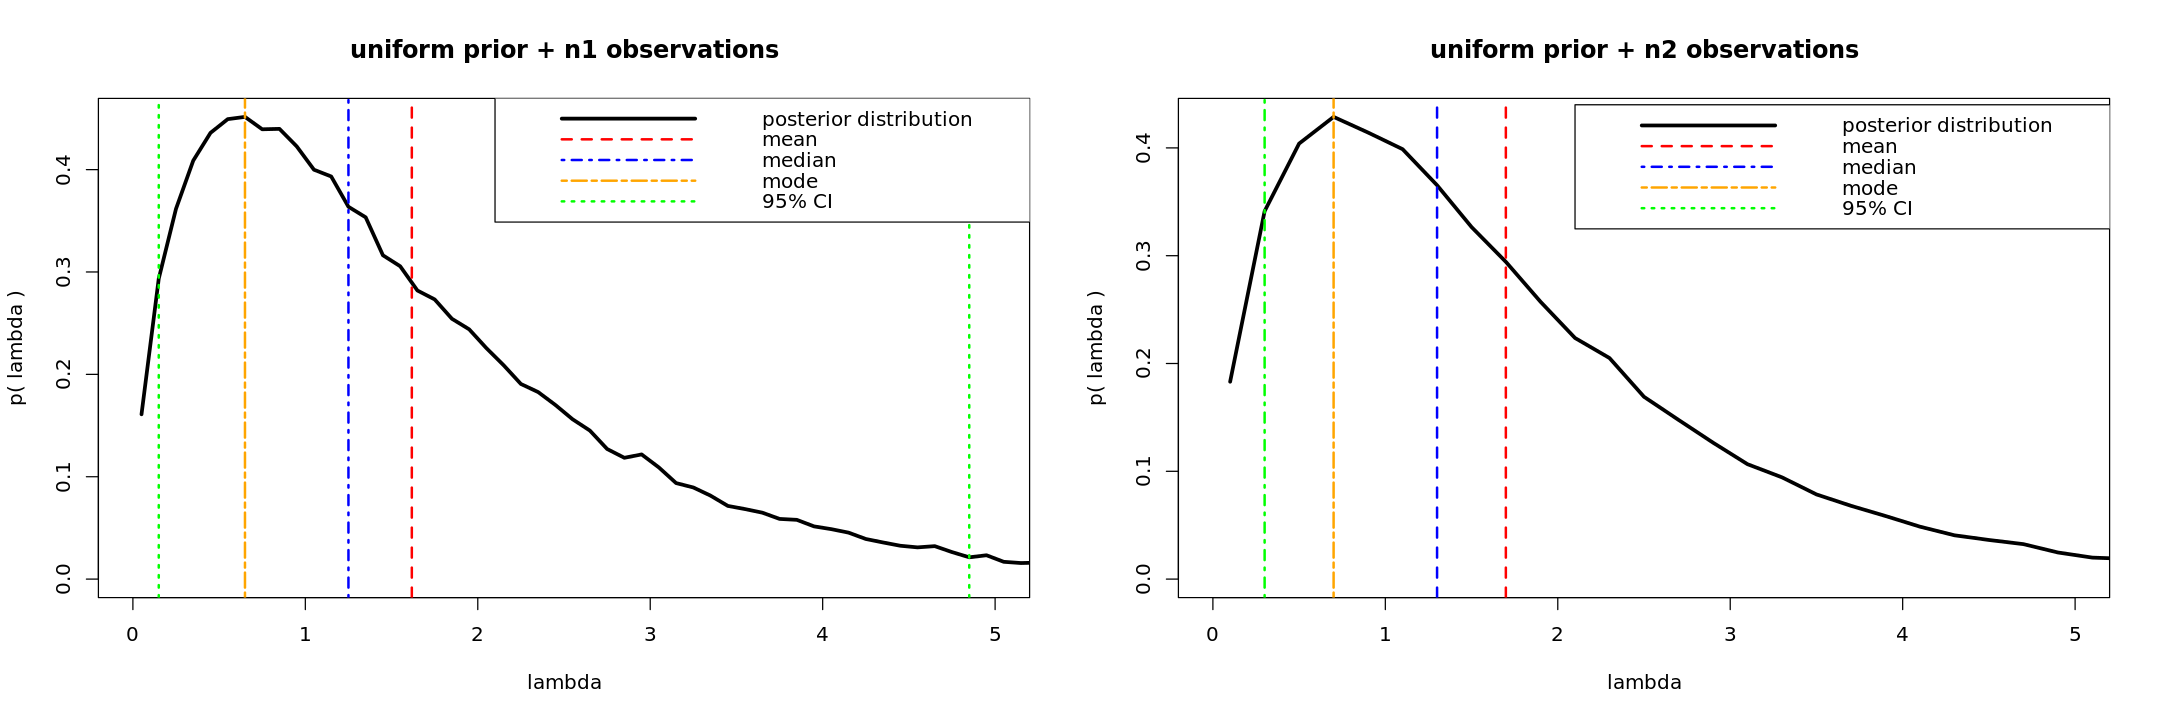

In [17]:
my_MCMC("uniform prior")

- assuming now a Jeffreys‚Äô prior, $$ g(\lambda) ‚àù 1/\sqrt{\lambda} \;\; \text{with} \;\; Œª > 0 $$ compute and plot the posterior distribution for Œª, the death rate over the measurement time. Determine the posterior mean, median and variance, and compute the 95% credibility interval.


estimator  n1_observations n2_observations
1 mean         0.617655        0.702326     
2 variance   162.705375      135.347036     
3 median       0.350000        0.450000     
4 low_lim_CI   0.050000        0.050000     
5 up_lim_CI    2.850000        3.050000     
6 mode         0.050000        0.050000

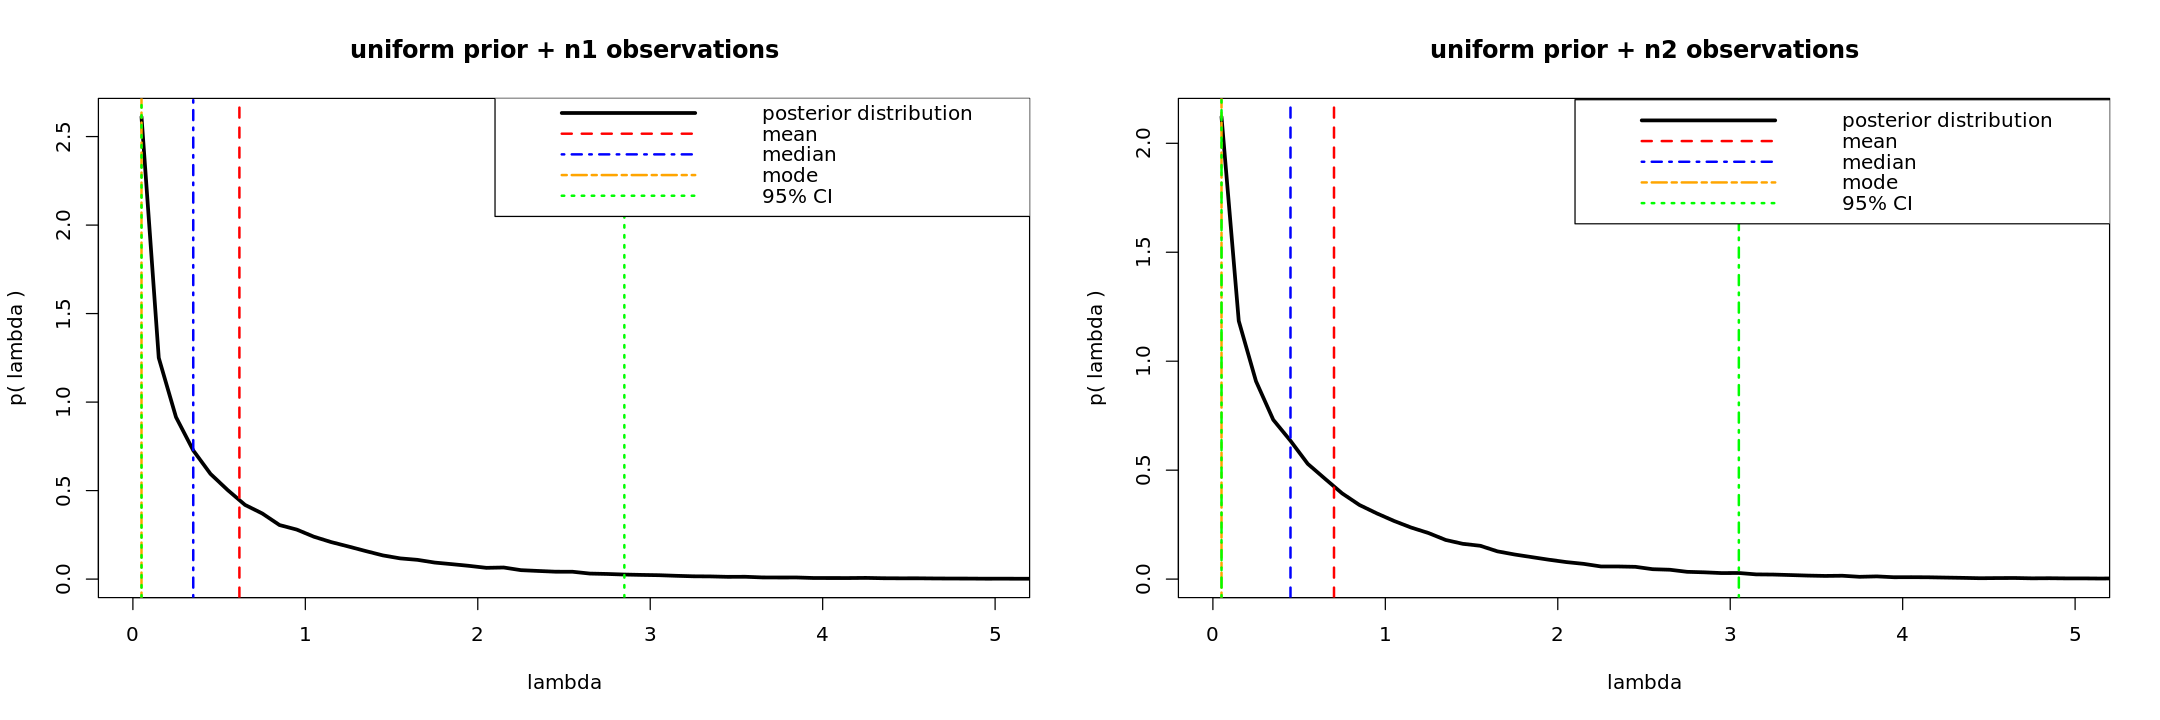

In [18]:
my_MCMC("Jeffreys' prior")

## Exercise 3
A study on water quality of streams, a high level of bacter X was defined as a level greater than 100 per 100 ml of stream water. n = 116 samples were taken from streams having a high environmental impact on pandas. Out of these, y = 11 had a high bacter X level. Indicating with p the probability that a sample of water taken from the stream has a high bacter X level:

In [19]:
# I initialize
# - the number of samples
n_tot <- 116
# - the number of samples having a high bacter X level
n_pos <- 11
# - the possible range of values for the probability
n_sample = 300
delta_p <- 1/n_sample
p <- seq(from=1/(2*n_sample), by=delta_p , length.out=n_sample)

a) find the frequentist estimator for p

In [20]:
# the frequentist estimator for the probability is
p_freq <- n_pos/n_tot
p_freq
p_freq_sigma <- p_freq*(1-p_freq)/n_tot
p_freq_sigma

[1] 0.09482759

[1] 0.0007399596

b) using a Beta(1, 10) prior for p, calculate and posterior distribution $P(p|y)$

In [21]:
# since the process is binomial, I can exploit the known properties of Beta distributions
# given a Beta(alpha,beta) prior, the posterior distribution is a Beta(alpha+n_pos, beta+n_tot-n_pos)
alpha_prior <- 1
beta_prior <- 10
prior_dist <- my_norm(dbeta(p, alpha_prior, beta_prior), delta_p)
alpha_post_0 <- alpha_prior + n_pos
beta_post_0 <- beta_prior + n_tot - n_pos
post_dist_0 <- my_norm(dbeta(p, alpha_post_0, beta_post_0), delta_p)

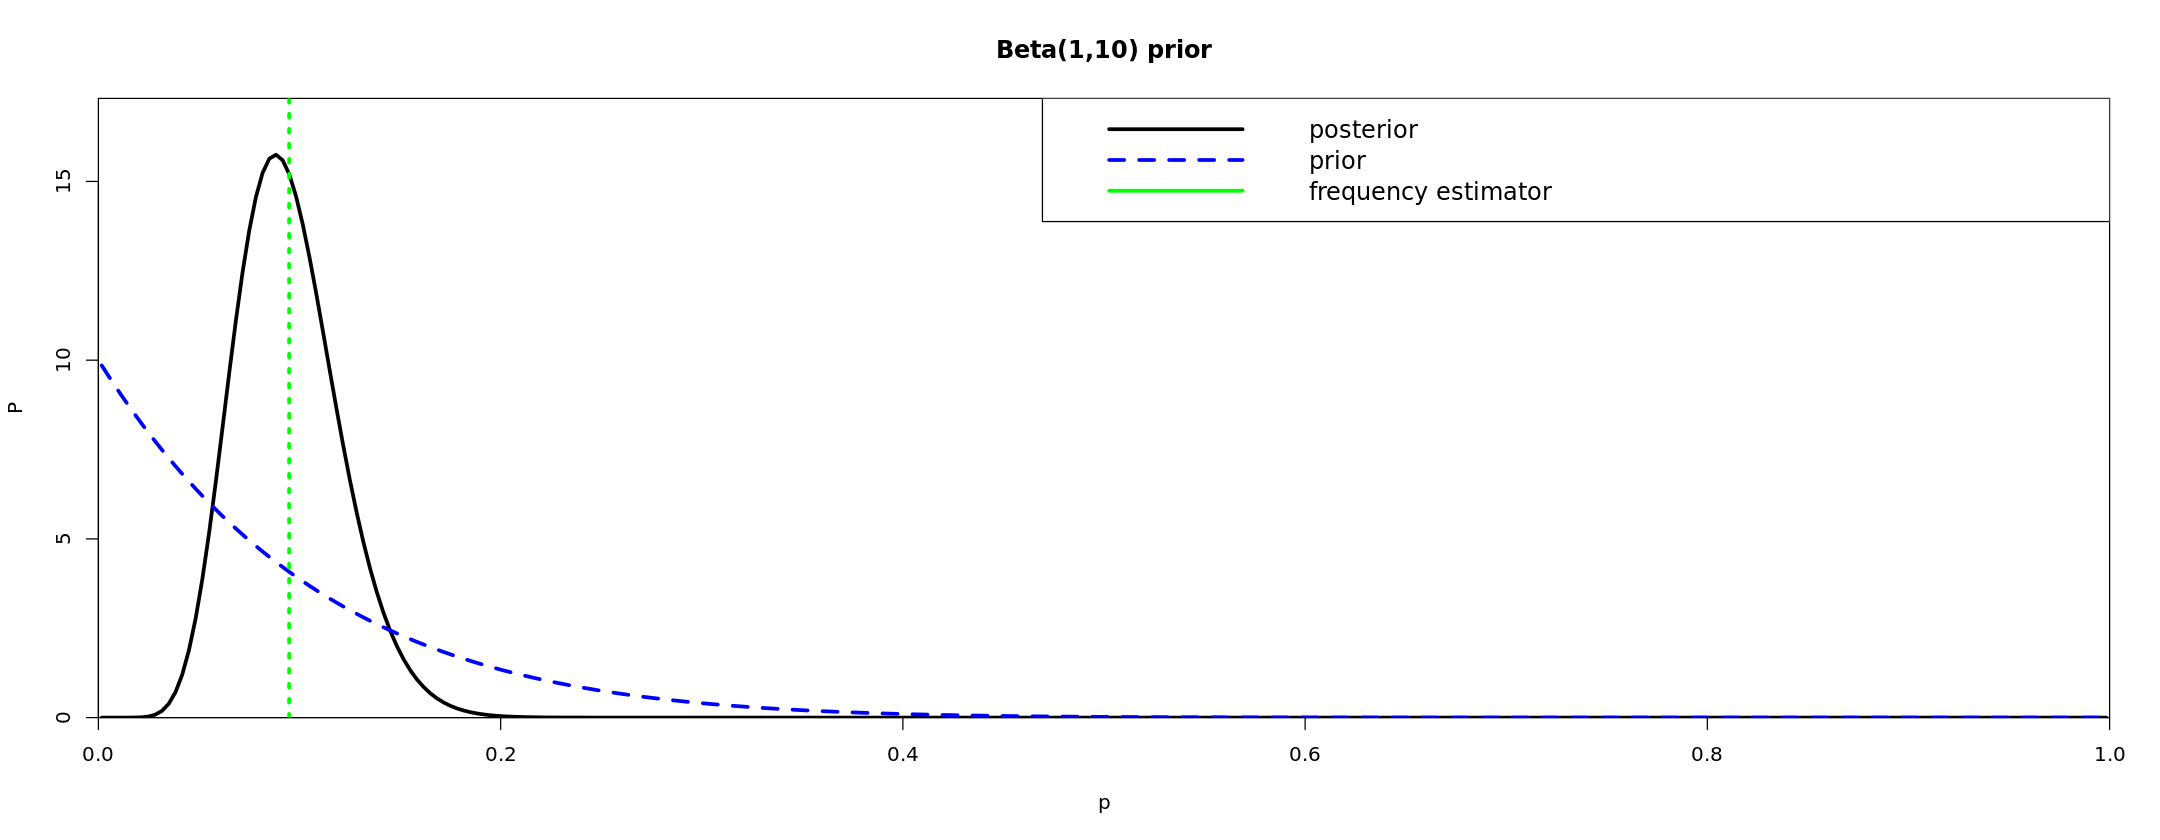

In [22]:
options(repr.plot.width=18, repr.plot.height=7)
plot(p, post_dist_0, type="l", lwd=3, col="black", xlim=c(0,1), ylim=c(0,1.1*max(post_dist_0)), xaxs="i", yaxs="i", xlab="p",
     ylab="P", main = "Beta(1,10) prior")
lines(p, prior_dist, type="l", lwd=3, col="blue", lty=2)
abline(v=p_freq, col='green', lwd=3, lty=3) 
legend("topright", legend=c("posterior", "prior", "frequency estimator"),
       col=c("black", "blue", "green"), lty = c(1, 2, 1), lwd=c(3, 3, 3), cex=1.2)

c) find the bayesian estimator for p, the posterior mean and variance, and a 95% credible interval

In [23]:
p_bayes <- p[which(post_dist_0 == max(post_dist_0))]
p_bayes_sigma <- delta_p
post_mean_0 <- my_mean(p, post_dist_0)
post_var_0 <- (my_std(p, post_dist_0))**2
post_lim_0 <- my_credibility_interval(post_dist_0, p, delta_p)

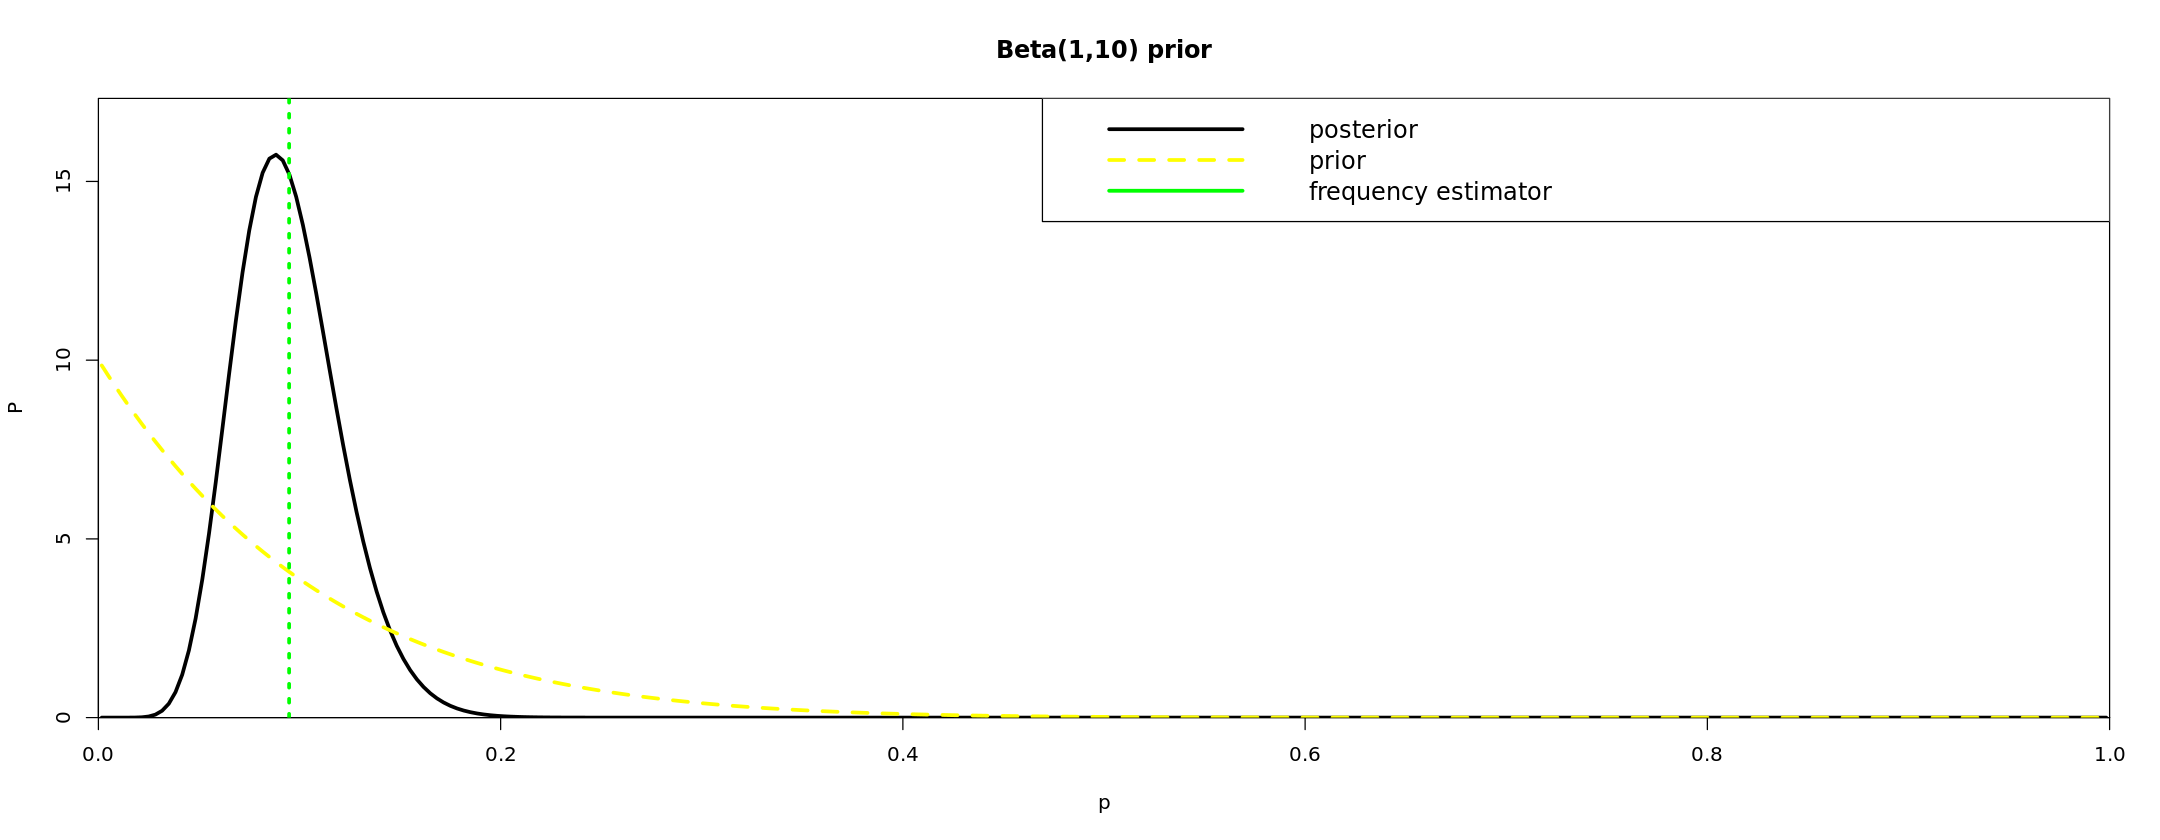

In [24]:
options(repr.plot.width=18, repr.plot.height=7)
plot(p, post_dist_0, type="l", lwd=3, col="black", xlim=c(0,1), ylim=c(0,1.1*max(post_dist_0)), xaxs="i", yaxs="i", xlab="p",
     ylab="P", main = "Beta(1,10) prior")
lines(p, prior_dist, type="l", lwd=3, col="yellow", lty=2)
abline(v=p_freq, col='green', lwd=3, lty=3) 
legend("topright", legend=c("posterior", "prior", "frequency estimator"),
       col=c("black", "yellow", "green"), lty = c(1, 2, 1), lwd=c(3, 3, 3), cex=1.2)

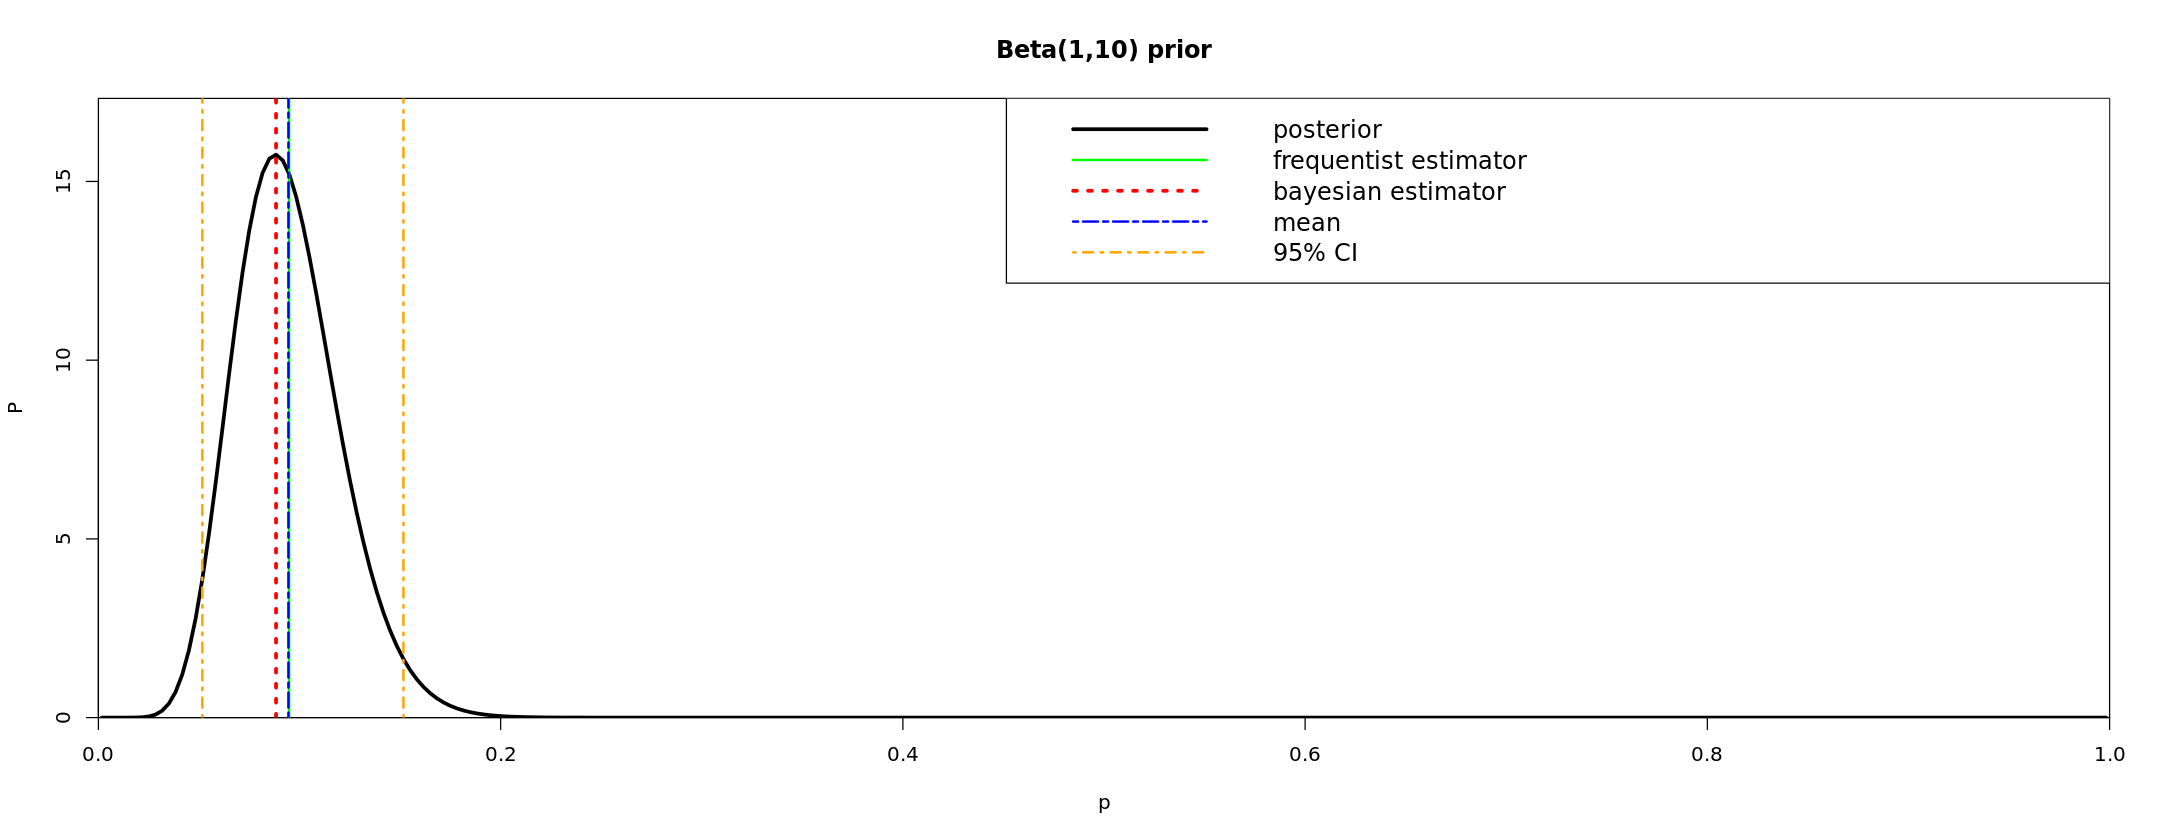

In [25]:
options(repr.plot.width=18, repr.plot.height=7)
plot(p, post_dist_0, type="l", lwd=3, col="black", xlim=c(0,1), ylim=c(0,1.1*max(post_dist_0)), xaxs="i", yaxs="i", xlab="p",
     ylab="P", main = "Beta(1,10) prior")
abline(v=p_freq, col='green', lwd=2, lty=1)
abline(v=p_bayes, col='red', lwd=3, lty=3)
abline(v=post_mean_0, col='blue', lwd=2, lty=6)
abline(v=post_lim_0[1], col='orange', lwd=2, lty=4)
abline(v=post_lim_0[2], col='orange', lwd=2, lty=4)
legend("topright", legend=c("posterior", "frequentist estimator", 'bayesian estimator', 'mean', "95% CI"),
       col=c("black", "green", 'red', 'blue', 'orange'), lty = c(1, 1, 3, 6, 4),lwd=c(3, 2, 3, 2, 2), cex=1.2)

d) test the hypotesis $$ H_0 : p = 0.1 \;\; \text{versus} \;\; H_1 : p \neq 0.1 $$ at 5% level of significance with both the frequentist and bayesian approach

In [26]:
alpha = 0.05
test_p = 0.1

In [27]:
# for the frequentist approach
n_sigma <- abs(test_p - p_freq)/p_freq_sigma

cat('frequentist approach: \n')
cat('since the result of the test hypothesis',round(n_sigma,0),'is much greater than the number of standard deviations (2)
corresponding to the significance level',alpha,', I can reject the null hypothesis at',alpha*100,"% significance level and
state that p ‚â† 0.1.")

frequentist approach: 
since the result of the test hypothesis 7 is much greater than the number of standard deviations (2)
corresponding to the significance level 0.05 , I can reject the null hypothesis at 5 % significance level and
state that p ‚â† 0.1.

In [28]:
# for the bayesian approach
n_sigma_bayes <- abs(test_p - p_bayes)/p_bayes_sigma
cat('bayesian approach: \n')
cat('since the result of the test hypothesis',round(n_sigma_bayes,0),'is much greater than the number of standard deviations 
(2) corresponding to the significance level',alpha,', I can reject the null hypothesis at',alpha*100,"% significance level and
state that p ‚â† 0.1.")

bayesian approach: 
since the result of the test hypothesis 4 is much greater than the number of standard deviations 
(2) corresponding to the significance level 0.05 , I can reject the null hypothesis at 5 % significance level and
state that p ‚â† 0.1.

A new measurement, performed one month later on n = 165 water samples, gives y = 9 high bacter X level

In [29]:
n_pos_new <- 9
n_tot_new <- 165

e)  find the frequentist estimator for p

In [30]:
p_freq_new <- n_pos_new/n_tot_new
p_freq_new
p_freq_sigma_new <- p_freq_new*(1-p_freq_new)/n_tot_new
p_freq_sigma_new

[1] 0.05454545

[1] 0.000312547

f) find a bayesian estimator for p, assuming both a Beta(1, 10) prior for p, and assuming the posterior probability of the older measurement as the prior for the new one.

In [31]:
# the bayesian estimator for p is the most likely value of p based on the posterior distribution 
# I find the posterior distribution by assuming an uniform prior (i.e. Beta(1,1))
prior_dist <- my_norm(dbeta(p, alpha_post_0, beta_post_0), delta_p)
alpha_post <- alpha_post_0 + n_pos_new
beta_post <- beta_post_0 + n_tot_new - n_pos_new
post_dist <- my_norm(dbeta(p, alpha_post, beta_post), delta_p)
p_bayes <- p[which(post_dist == max(post_dist))]
post_mean <- my_mean(p, post_dist)
post_var <- (my_std(p, post_dist))**2
post_lim <- my_credibility_interval(post_dist, p, delta_p)
p_bayes_new <- p[which(post_dist == max(post_dist))]
p_bayes_sigma_new <- delta_p

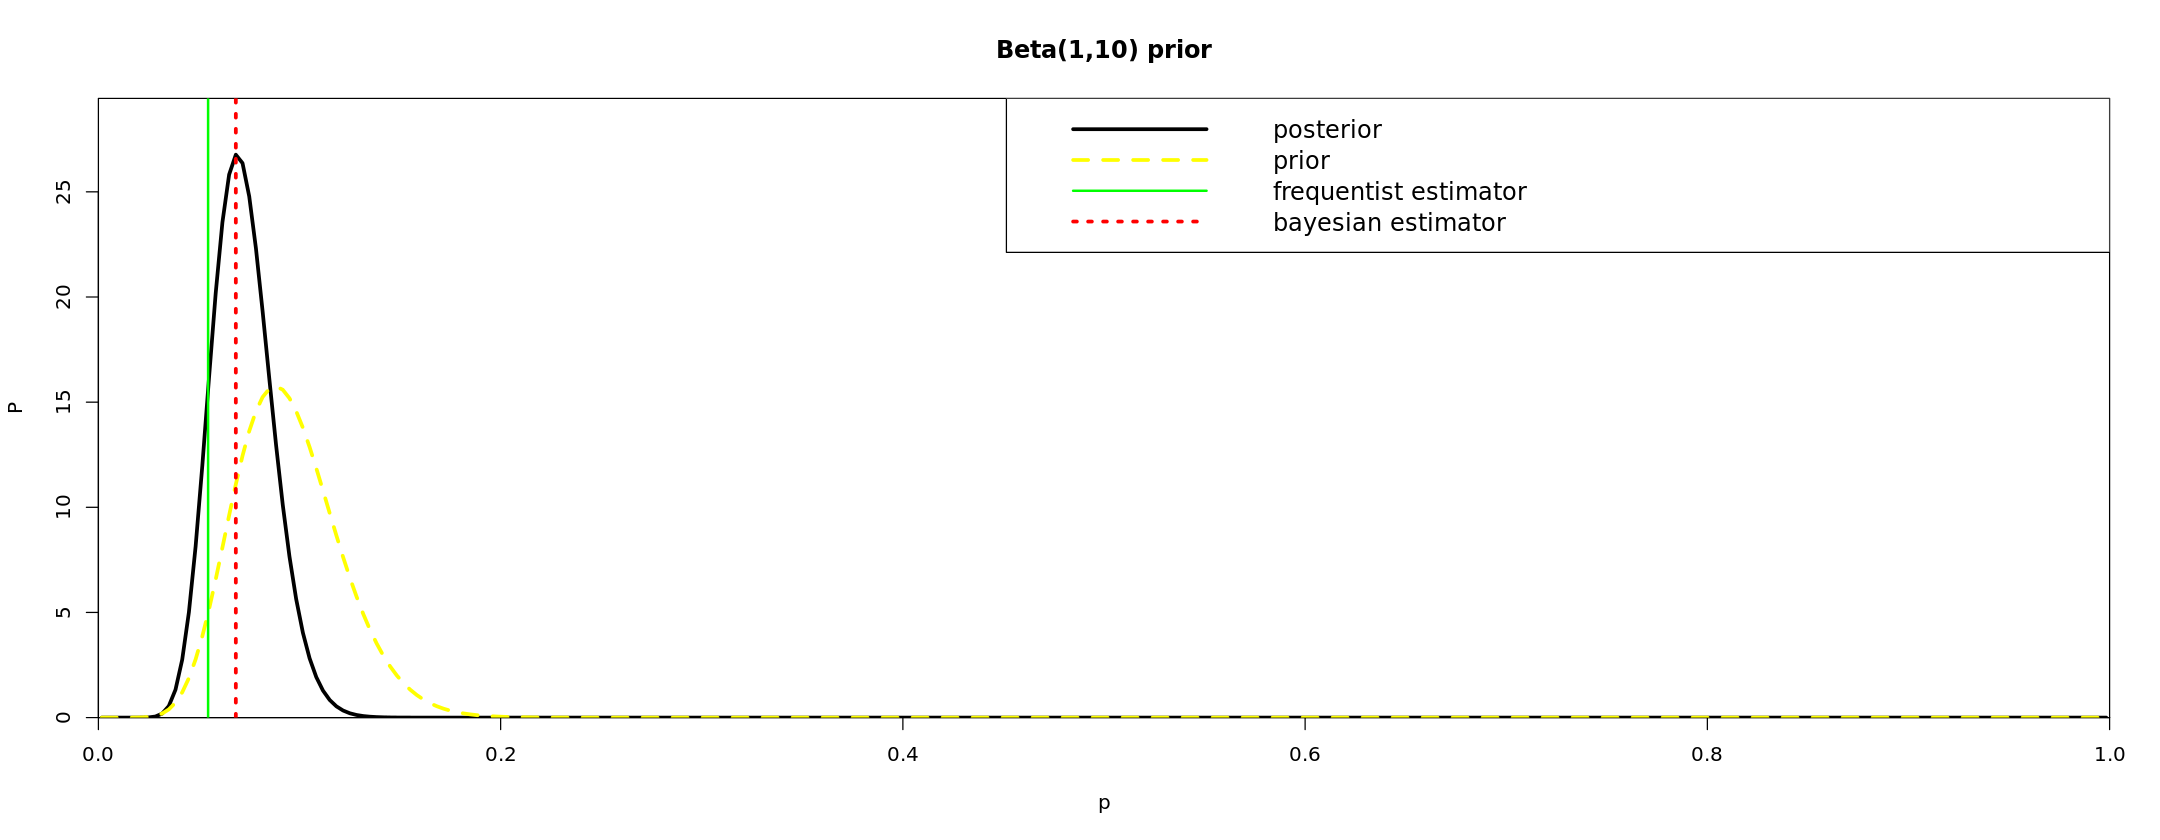

In [32]:
options(repr.plot.width=18, repr.plot.height=7)
plot(p, post_dist, type="l", lwd=3, col="black", xlim=c(0,1), ylim=c(0,1.1*max(post_dist)), xaxs="i", yaxs="i", xlab="p",
     ylab="P", main = "Beta(1,10) prior")
lines(p, post_dist_0, type="l", lwd=3, col="yellow", lty=2)
abline(v=p_freq_new, col='green', lwd=2, lty=1)
abline(v=p_bayes_new, col='red', lwd=3, lty=3)
legend("topright", legend=c("posterior", "prior", "frequentist estimator", 'bayesian estimator'),
       col=c("black", "yellow", "green", 'red'), lty = c(1, 2, 1, 3),lwd=c(3, 3, 2, 3), cex=1.2)

g) find the bayesian estimator for p, the posterior mean and variance, and a 95% credible interval

In [33]:
# I use the known formulas
post_mean <- my_mean(p, post_dist)
post_var <- (my_std(p, post_dist))**2
post_lim <- my_credibility_interval(post_dist, p, delta_p)

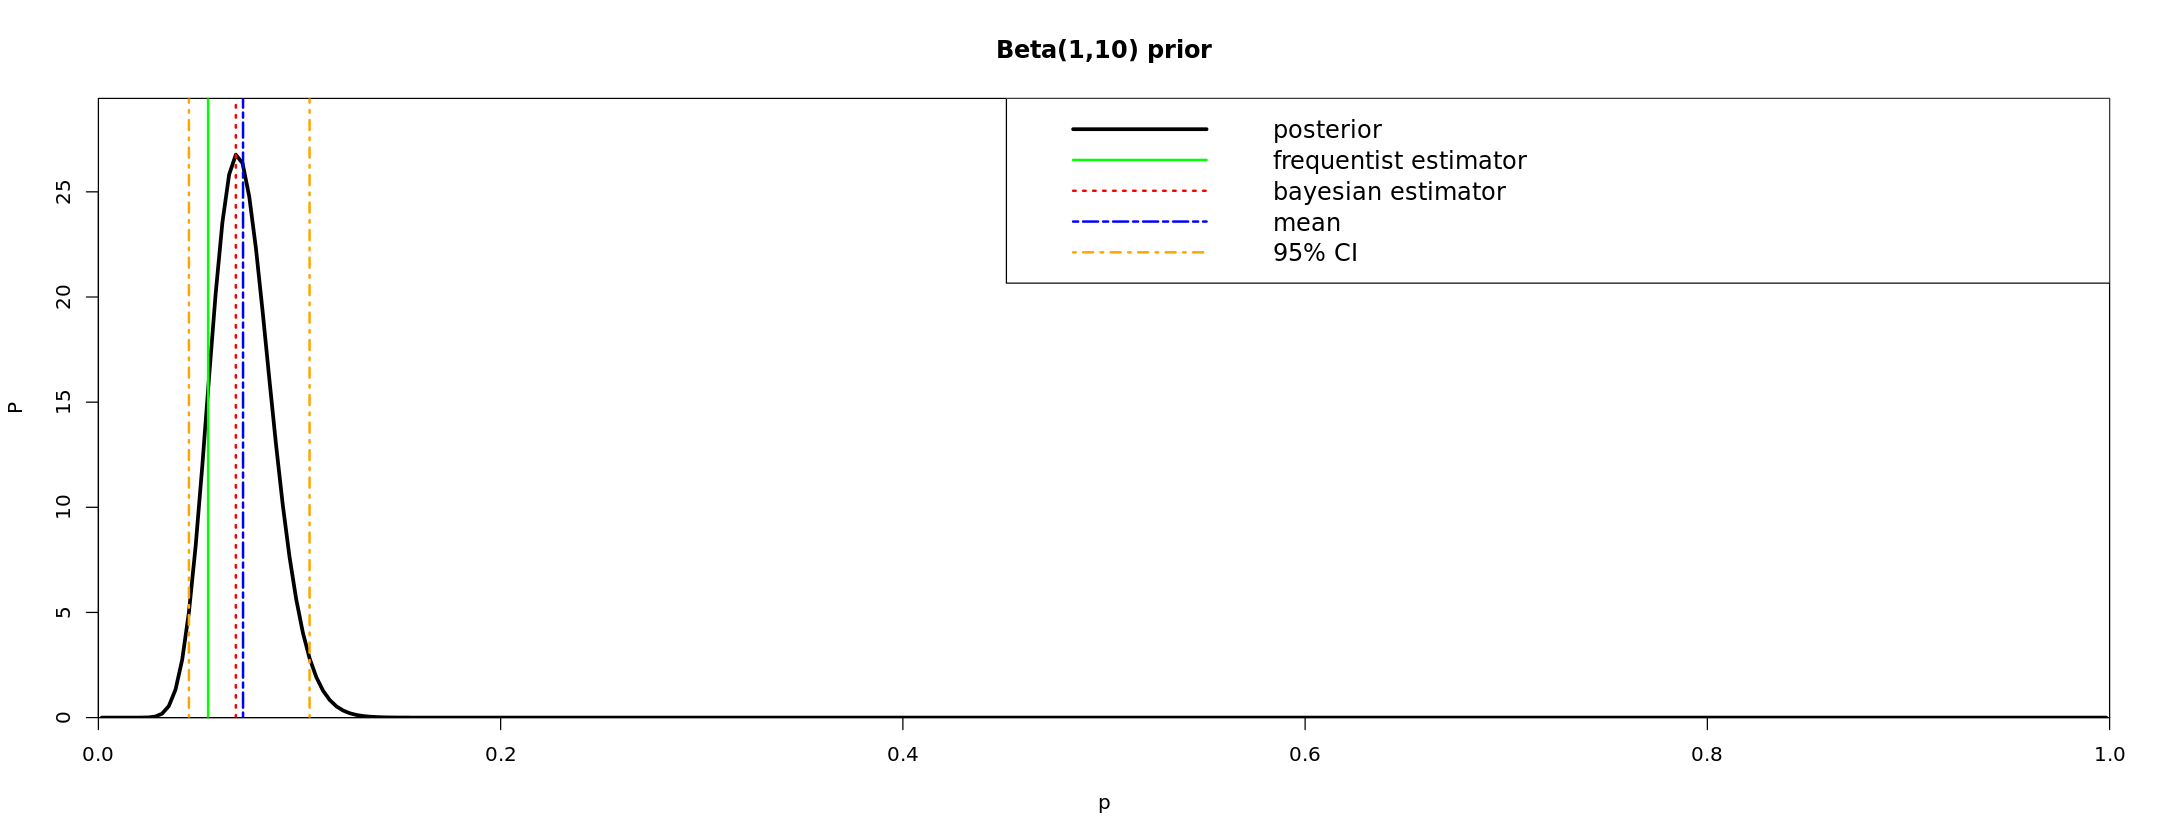

In [34]:
options(repr.plot.width=18, repr.plot.height=7)
plot(p, post_dist, type="l", lwd=3, col="black", xlim=c(0,1), ylim=c(0,1.1*max(post_dist)), xaxs="i", yaxs="i", xlab="p",
     ylab="P", main = "Beta(1,10) prior")
abline(v=p_freq_new, col='green', lwd=2, lty=1)
abline(v=p_bayes_new, col='red', lwd=2, lty=3)
abline(v=post_mean, col='blue', lwd=2, lty=6)
abline(v=post_lim[1], col='orange', lwd=2, lty=4)
abline(v=post_lim[2], col='orange', lwd=2, lty=4)
legend("topright", legend=c("posterior", "frequentist estimator", 'bayesian estimator', 'mean', "95% CI"),
       col=c("black", "green", 'red', 'blue', 'orange'), lty = c(1, 1, 3, 6, 4),lwd=c(3, 2, 2, 2, 2), cex=1.2)

h) test the hypotesis $$ H_0 : p = 0.1 \;\; \text{versus} \;\; H_1 : p \neq 0.1 $$ at 5% level of significance with both the frequentist and bayesian approach

In [35]:
# I use a one side hypothesis test and set as null hypothesis that p < 0.1

In [36]:
alpha = 0.05
test_p = 0.1

In [37]:
# for the frequentist approach
n_sigma_freq <- abs(test_p - p_freq_new)/p_freq_sigma_new

cat('frequentist approach: \n')
cat('since the result of the test hypothesis',round(n_sigma_freq,0),'is much greater than the number of standard deviations (2)
corresponding to the significance level',alpha,', I can reject the null hypothesis at',alpha*100,"% significance level and
state that p ‚â† 0.1.")

frequentist approach: 
since the result of the test hypothesis 145 is much greater than the number of standard deviations (2)
corresponding to the significance level 0.05 , I can reject the null hypothesis at 5 % significance level and
state that p ‚â† 0.1.

In [38]:
# for the bayesian approach
n_sigma_bayes <- abs(test_p - p_bayes_new)/p_bayes_sigma_new
cat('bayesian approach: \n')
cat('since the result of the test hypothesis',round(n_sigma_bayes,0),'is much greater than the number of standard deviations 
(2) corresponding to the significance level',alpha,', I can reject the null hypothesis at',alpha*100,"% significance level and
state that p ‚â† 0.1.")

bayesian approach: 
since the result of the test hypothesis 10 is much greater than the number of standard deviations 
(2) corresponding to the significance level 0.05 , I can reject the null hypothesis at 5 % significance level and
state that p ‚â† 0.1.

## Exercise 4
Analyze the data of Exercise 3 and solve points (b) and (c) using a MCMC with JAGS

b) using a Beta(1, 10) prior for p, calculate and posterior distribution  ùëÉ(ùëù|ùë¶)

c) find the bayesian estimator for p, the posterior mean and variance, and a 95% credible interval

estimator  data     
1 mean       0.1022224
2 variance   0.1713565
3 median     0.1010000
4 low_lim_CI 0.0550000
5 up_lim_CI  0.1630000
6 mode       0.0950000

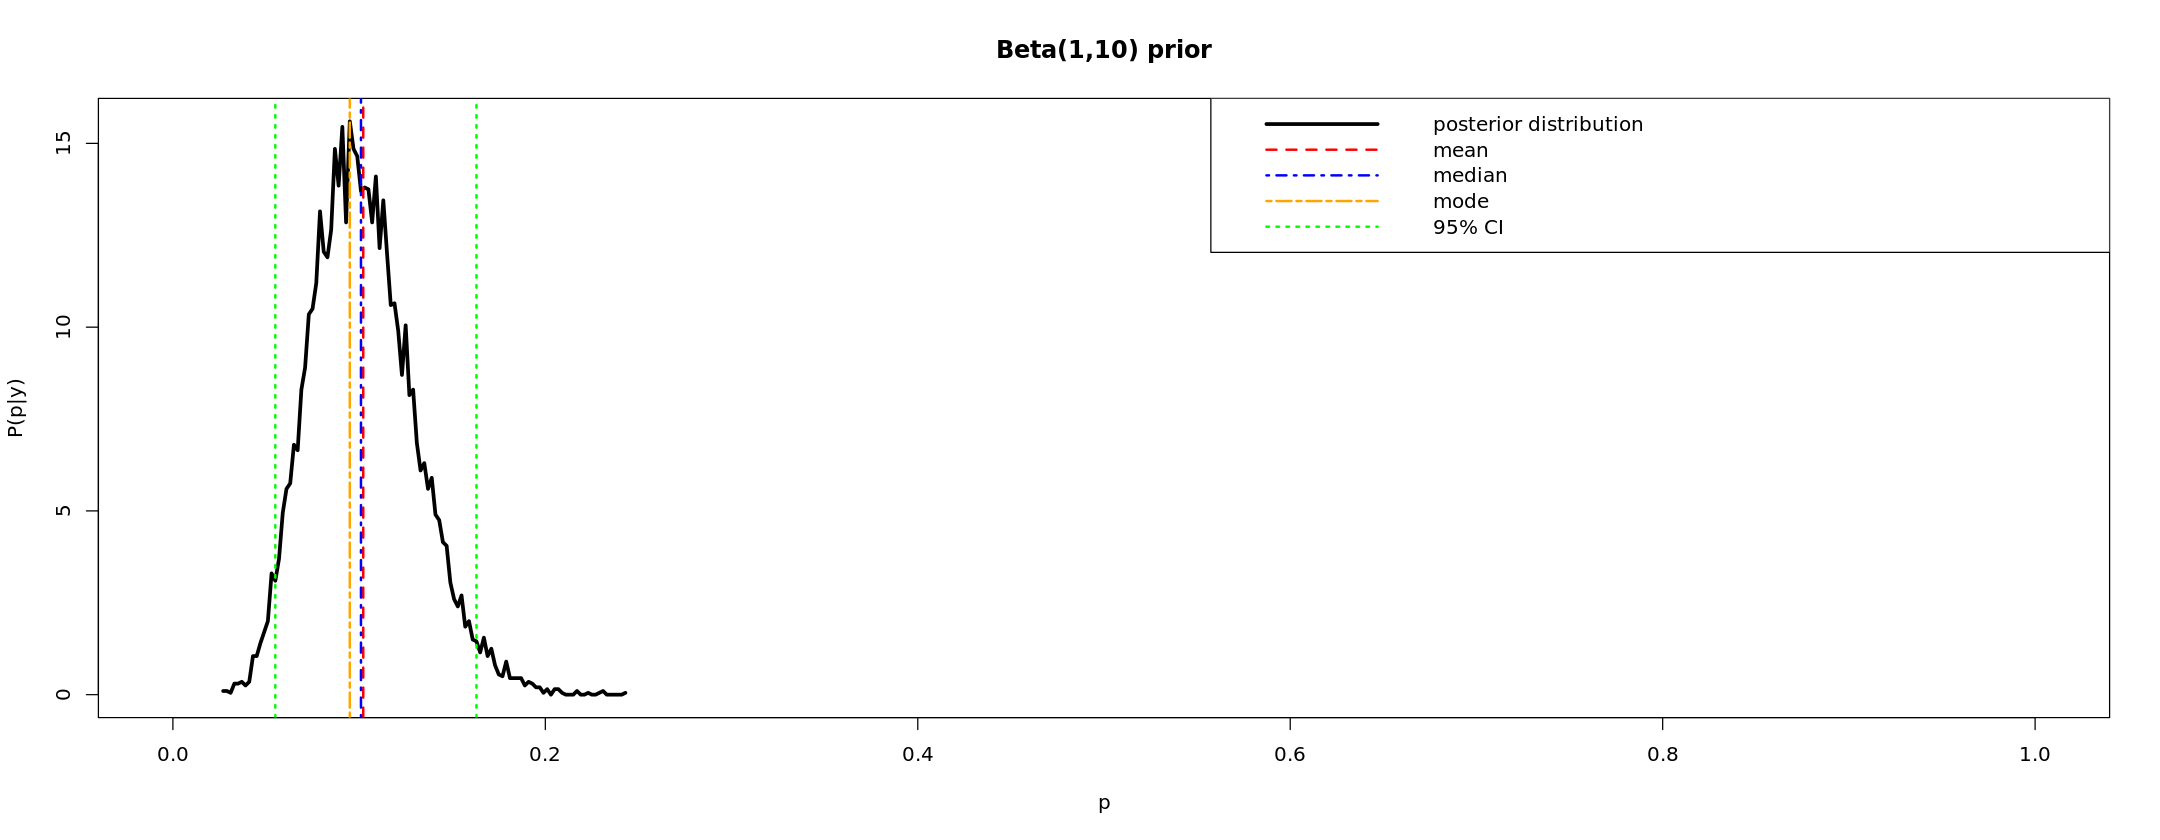

In [39]:
# I initialize the parameters that are related to the pieces of data given by the 
data_obs <- c(rep(1,times=n_pos), rep(0,times=n_tot - n_pos))

data <- NULL
data$X <- data_obs # Set of observations
#data$n <- length(data_obs) # those to be considered
data$n_next <- 10 # Prediction

# and the MCMC model itself
model = 'Brisigotti_Erica_rlab05_beta_prior_MCMC.bug'
jm <- jags.model(model , data, quiet=TRUE)             
# I update the Markov chain by setting the number of iterations
update(jm, 10000)
# I then sample from the MCMC algorithm
chain <- coda.samples(jm, variable.names = c("p",'y'), n.iter = 10000)
# and save my chain in a dataframe format
df <- as.data.frame( as.mcmc(chain) )

temp_1 <- hist(df$p, plot=FALSE, nc=100)
# I update the terminology to match the wording used in the previous sections of the code
post_dist_1 <- temp_1$density
y_1 <- temp_1$mids
delta_y_1 <- y_1[2]-y_1[1]

st <- data.frame( estimator=NA, data=NA )
mean_1 <- my_mean(y_1, post_dist_1)
st[1,] = c('mean', mean_1)
var_1 <- (my_std(y_1, post_dist_1))**2
st[2,] = c('variance', var_1)
med_1 <- my_median(post_dist_1, y_1, delta_y_1)
st[3,] = c('median', med_1)
lim_1 <- my_credibility_interval(post_dist_1, y_1, delta_y_1)
st[4,] = c('low_lim_CI', lim_1[1])
st[5,] = c('up_lim_CI', lim_1[2])
mode_1 <- my_mode(y_1, post_dist_1)
st[6,] = c('mode', mode_1)

# I can finally plot everything I want to show, all together
options( repr.plot.width=18, repr.plot.height=7)

plot(y_1, post_dist_1, col='black', type='l', lwd=3, lty=1, main="Beta(1,10) prior", xlab='p',
     ylab='P(p|y)', xlim=c(0,1))
abline(v=mean_1, col='red', lwd=2, lty=2)
abline(v=med_1, col='blue', lwd=2, lty=4)
abline(v=mode_1, col='orange', lwd=2, lty=6)
abline(v=lim_1, col='green', lwd=2, lty=3)
legend('topright', legend=c("posterior distribution","mean",'median','mode','95% CI'),
       col=c('black','red','blue','orange','green'), lty = c(1, 2, 4, 6, 3), lwd=c(3, 2, 2, 2, 2))

st %>% mutate( data=as.numeric(data)) -> st
st